# Machine Learning in Network Science
Group Challenge

***
by: Leonardo Basili, Paul Bédier, Lasse Schmidt

within: MS Data Sciences & Business Analytics

at: CentraleSupélec & ESSEC Business School
***

This notebook covers deep learning techniques, namely:
- Variational Graph Normalized Auto-Encoders (based on https://arxiv.org/abs/2108.08046) which allow us to learn graph embeddings in an unsupervised way (based on graph structure and node embeddings)

### 1. Import Packages

In [6]:
from importlib import reload
reload(analyseData)
reload(prepData)
reload(loadData)
reload(modeling)
reload(autoenc)

<module 'util.autoencoder' from 'D:\\Dokumente\\2_Bildung\\2_MSc\\1_Classes\\Y2T2_Machine Learning in Network Science\\3_challenge\\Network-Science_Challenge\\util\\autoencoder.py'>

In [1]:
# import own scripts
import util.analyse_Data as analyseData
import util.preprocess_Data as prepData
import util.load_Data as loadData
import util.modeling as modeling
import util.autoencoder as autoenc

In [2]:
# parse & handle data
import os
import numpy as np
import pandas as pd

# modeling
import torch
from torch_geometric.nn import GAE, VGAE

# hyperparam optimization
from ray import tune, air

# evaluation
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


# visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# set matplotlib and seaborn settings for nicer plots
%matplotlib inline

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### 2. Load Data for Modeling

In [5]:
# might take up to a minute
data, (G, G_train, node_info, train_tf, val_tf, trainval_tf, test, test_tf) = autoenc.load(testing_ratio = 0.2)

Number of positive edges for training: 4174
Number of positive edges for validation: 1043
Number of edges in original graph: 5217
Number of edges in training graph: 4174
The graph is connected
Enriching node features...
Create PyTorch Geometric dataset...


In [6]:
# where to save trial results to
ray_path = os.path.abspath("")+"\\ray_results\\"
if not os.path.isdir(ray_path):
    os.mkdir(ray_path)

### 3. VGNAE Node Embeddings

https://github.com/SeongJinAhn/VGNAE/blob/main/main.py for Variational Graph Normalized Auto-Encoders

#### 3.1 Hyperparameter tuning

In [15]:
# tunable hyperparameter search space --> search using tune.choice([]), tune.uniform(lower, upper), tune.grid_search([])
config = {
    # log params in raytune
    "ray": True,
    
    # print results per epoch
    "verbose": False,
    
    # basic infos
    "data": data,
    "max_epochs": 50,
    "save": True, # if we want to save best model on validation set
    
    # model
    "model": "VGNAE",
    
    ## encoder
    "enc_channels": 64,
    "scaling": 1.8,
    "num_prop": tune.grid_search([4, 16, 32, 64, 128]),
    "teleport": 0, # tune.grid_search([0, 0.1, 0.2]),
    "dropout": 0, # tune.grid_search([0, 0.1, 0.2]),
    
    # optimizer
    "lr": tune.grid_search([1e-3, 1e-4, 1e-5]),
    "wd": 0,
}

In [16]:
# how many trials to run (if grid_search utilized, it will run this number per grid_search value)
num_samples = 1

# run experiment
result_grid = autoenc.run_ray_experiment(
    autoenc.train_validate, config, ray_path, num_samples,
    metric_columns = ["trn_auc", "val_auc", "max_val_auc", "training_iteration"],
    parameter_columns = ["scaling", "num_prop", "lr"]
)

2023-03-23 17:26:49,653	INFO tune.py:798 -- Total run time: 248.39 seconds (229.34 seconds for the tuning loop).


#### 3.2 Result of Hyperparameter tuning

In [6]:
restored_tuner, result_grid = autoenc.open_validate_ray_experiment(
    "ray_results/2_VGNAE_fine search",
    autoenc.train_validate
)

The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.


Loading results from ray_results/2_VGNAE_fine search...
Done!

No errors! Number of terminated trials: 75


In [17]:
# get best score per trial (highest validation accuracy)
N = 10
best_result_df = result_grid.get_dataframe(
    filter_metric="val_auc", filter_mode="max"
)
best_result_df = best_result_df[["trial_id", "training_iteration", "config/enc_channels",
                                 "config/scaling", "config/num_prop", "config/lr", "config/wd", 
                                 "trn_loss", "val_loss", "trn_auc", "val_auc"]]
best_result_df = best_result_df.sort_values(by=["val_auc"], ascending = False)

if len(result_grid) > N:
    best_result_df = best_result_df.head(N)

best_result_df

,trial_id,training_iteration,config/enc_channels,config/scaling,config/num_prop,config/lr,config/wd,trn_loss,val_loss,trn_auc,val_auc
1,ef228_00001,1,64,1.8,4,0.00010,0,10.095224,4.476958,0.741760,0.711898
2,ef228_00002,1,64,1.8,4,0.00001,0,10.095224,4.484480,0.741282,0.711898
0,ef228_00000,1,64,1.8,4,0.00100,0,10.095224,4.399359,0.744149,0.709987
4,ef228_00004,27,64,1.8,16,0.00010,0,9.554084,4.345303,0.742716,0.707120
7,ef228_00007,27,64,1.8,32,0.00010,0,9.554212,4.345518,0.742357,0.707120
10,ef228_00010,27,64,1.8,64,0.00010,0,9.554212,4.345518,0.742357,0.707120
13,ef228_00013,27,64,1.8,128,0.00010,0,9.554213,4.345518,0.742357,0.707120
3,ef228_00003,2,64,1.8,16,0.00100,0,9.845572,4.457172,0.737579,0.705209
6,ef228_00006,2,64,1.8,32,0.00100,0,9.845717,4.457353,0.737460,0.705209
9,ef228_00009,2,64,1.8,64,0.00100,0,9.845716,4.457353,0.737460,0.705209


#### 3.3 Embeddings based on best model

In [14]:
# load best autoencoder
path = os.path.abspath("")+"\\models\\autoencoder.pt"
model = VGAE(autoenc.Encoder(data.x.size()[1], 64, 1.5, 4, 0, 0))
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [19]:
# get embeddings of nodes
embedding = autoenc.get_embeddings(model, data.x, data.train_pos_edges)

Text(0.5, 1.0, 'VGNAE projection (first 2 dim) of nodes')

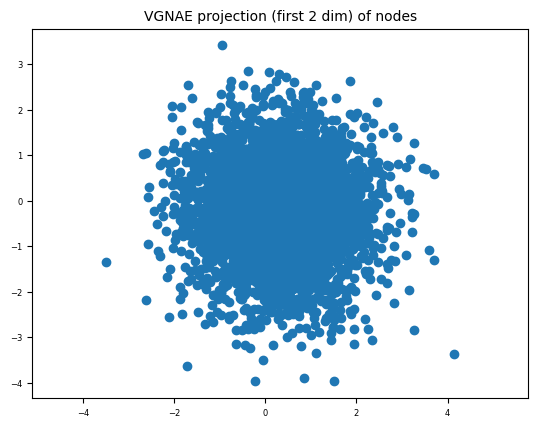

In [20]:
# plot embedding
plt.scatter(
    embedding[:, 0],
    embedding[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('VGNAE projection (first 2 dim) of nodes')

Embeddings look like a sphere, we cannot do any meaningful clusering based on this.

Let us now take our original VGNAE embeddings and put them into a pandas dataframe.

In [21]:
node_emb = pd.DataFrame(embedding).rename(columns = {val: f"x{val+1}" for val in range(embedding.shape[1])})

node_emb

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64
0,0.997071,-0.569476,0.099492,1.770889,-0.289025,1.496010,0.314600,-0.790011,-1.842178,-1.569338,...,1.862246,0.093979,1.784731,0.550283,-1.871324,0.957955,2.847600,1.938954,-0.079856,1.018597
1,-0.071352,1.244380,0.955698,-0.114192,0.903962,-0.603017,-0.505089,-1.074332,0.651185,0.365505,...,1.061382,0.732869,-0.258655,0.526837,0.862173,0.432812,-0.175384,2.014951,-1.202015,0.634952
2,2.867577,-0.695617,-0.909999,-0.219585,-0.226042,-0.660466,-0.204073,0.393031,1.893696,0.865087,...,-0.630161,-0.783322,-0.234918,-0.685481,0.325459,0.176680,0.387911,0.980215,-0.193003,0.919945
3,-1.085987,0.020585,0.624360,0.575737,-0.081215,0.661051,2.023026,-0.703336,0.123392,0.072961,...,-1.947037,-0.128079,0.771275,-0.586532,0.869936,0.311723,-0.517847,-0.828687,-0.077901,0.542578
4,-0.111463,-0.891799,-0.352767,0.272374,-0.243427,-0.419829,1.157166,1.383824,0.612440,2.069523,...,-0.796456,-0.584228,-0.443619,-0.031951,0.310150,-0.279820,-1.397200,-0.970400,0.876664,1.714804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3592,-0.591717,0.888862,0.621995,-0.633513,0.576470,0.186928,-1.455729,0.739141,-1.306635,-0.192654,...,-0.627417,-0.030068,-1.212708,-0.087929,-1.089786,1.097817,1.263022,-0.215117,-0.601797,-1.097092
3593,0.402709,-1.005643,0.463547,0.056492,0.926115,0.098112,0.942940,-0.196954,-1.794956,-0.249557,...,1.940788,1.556548,0.483246,-3.942598,0.844724,0.757136,0.765465,-0.356413,0.530495,0.005907
3594,0.507469,1.467487,-0.051609,-0.563099,1.791867,0.108168,0.699620,0.848376,-1.009218,1.145778,...,0.850527,-0.130299,0.284307,0.721657,-1.207154,0.737002,-1.381206,0.714541,0.803719,1.343314
3595,-0.288709,0.968297,0.105678,0.749759,0.972262,-0.604261,-1.021591,1.132221,-0.776064,-0.402250,...,-0.227707,-0.451159,1.672031,-0.827310,-1.367546,0.038120,-1.721147,-0.546552,1.931648,0.828025


#### 3.4 Compute edge features based on best model

In [22]:
# predict train
y_train_hat = pd.DataFrame(autoenc.get_similarity(model, data.x, data.train_pos_edges, data.train_edges))
y_train_hat = (y_train_hat
    .rename(columns = {0: "sim"})
    .assign(y = trainval_tf.loc[trainval_tf.train_mask == True].y.values)
    .assign(pred = lambda df_: (df_.sim > df_.sim.median()).astype(int))
)
print("ROC: ", roc_auc_score(y_train_hat.y, y_train_hat.sim))
print("Acc: ", accuracy_score(y_train_hat.y, y_train_hat.pred))

ROC:  0.8420662045281327
Acc:  0.7385072725342393


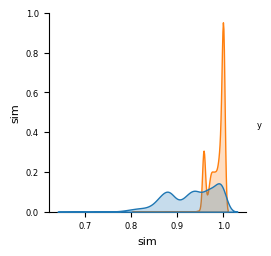

In [23]:
sns.pairplot(y_train_hat[["sim", "y"]], hue = "y")

In [26]:
# predict val
y_val_hat = pd.DataFrame(autoenc.get_similarity(model, data.x, data.train_pos_edges, data.val_edges))
y_val_hat = (y_val_hat
    .rename(columns = {0: "sim"})
    .assign(y = trainval_tf.loc[trainval_tf.val_mask == True].y.values)
    .assign(pred = lambda df_: (df_.sim > df_.sim.median()).astype(int))
)
print("ROC: ", roc_auc_score(y_val_hat.y, y_val_hat.sim))
print("Acc: ", accuracy_score(y_val_hat.y, y_val_hat.pred))

ROC:  0.7887304633945709
Acc:  0.7093690248565966


In [21]:
tmp = (val_tf
    .assign(sim  = y_val_hat.pred.values)
    .assign(dist = lambda df_: [np.linalg.norm(node_emb.loc[u].values-node_emb.loc[v].values) for u, v in zip(df_.node1, df_.node2)])
)

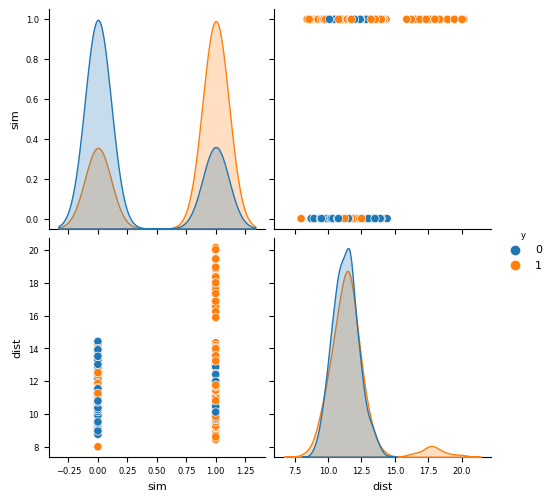

In [22]:
sns.pairplot(tmp[["sim", "dist", "y"]], hue = "y")

In [23]:
tmp.corr()

,node1,node2,y,sim,dist
node1,1.000000,0.493127,0.036595,0.267447,-0.002811
node2,0.493127,1.000000,0.059586,0.329002,-0.036501
y,0.036595,0.059586,1.000000,0.439084,0.116431
sim,0.267447,0.329002,0.439084,1.000000,0.155171
dist,-0.002811,-0.036501,0.116431,0.155171,1.000000


In [49]:
# predict test
y_test_hat = pd.DataFrame(autoenc.get_similarity(model, data.x, data.trainval_pos_edges, data.test_edges))
y_test_hat = (y_test_hat
    .rename(columns = {0: "sim"})
    .assign(pred = lambda df_: (df_.sim > df_.sim.median()).astype(int))
)
y_test_hat[["pred"]].value_counts()

pred
0       1741
1       1740
dtype: int64

### X. Code Graveyard

previous code without functions

In [ ]:
from importlib import reload
reload(officialData)

In [50]:
import util.official_Data as officialData

In [51]:
enriched_test = officialData.enrich_test()

In [52]:
enriched_test_tf = pd.merge(test_tf, enriched_test, how = "left", on = ["node1", "node2"])
y_col = enriched_test_tf.pop("y")
enriched_test_tf.insert(2, "y", y_col)

In [53]:
enriched_test_tf.y.value_counts()

0    1748
1    1733
Name: y, dtype: int64

In [54]:
roc_auc_score(enriched_test_tf.y, y_test_hat.pred)

0.7061221397531562